In [3]:
using Plots, LinearAlgebra, CSV, DataFrames, Statistics

In [4]:
function DM_LSS(z, H0, Ωb, Ωm ;del_z = 0.1)
    # z: redshift
    # H0: Hubble constant # km/s/Mpc
    # Ωm: matter density
    # returns: DM_LSS in pc/cm^3
    
    # constants
    G = 6.67408e-11 # m^3 kg^-1 s^-2
    c = 299792.458 # km/s
    m_p = 1.6726219e-27 # kg
    pc_in_cm = 3.08567758149137e18 # cm

    # parameters
    chi_e = 0.88
    fIGM = 0.84
    prefactor = chi_e*fIGM*3*c*Ωb*H0/(8*pi*m_p*G)

    # integration
    z_bins = collect(0:del_z:z)
    ez_bins = sqrt.(Ωm*(1 .+ z_bins).^3 .+ (1-Ωm))
    
    dmlss =  prefactor*sum(((1 .+ z_bins)./ez_bins)*del_z) # pc^-1 m^-1
    dmlss = dmlss/(pc_in_cm*10)^2 # pc/cm^3

end

function DM_host(z)
    return 100/(1+z) # pc cm^-3
end

function DM_theo(z, H0, Ωb, Ωm ;del_z = 0.1)
    return DM_LSS(z, H0, Ωb, Ωm, del_z = del_z) + DM_host(z) # pc cm^-3     
end

function sigma_DM_sqr_i(z)
    return 30^2 + (50/(1+z))^2 + (40 + 140*z)^2 # (pc cm^-3)^2
end

function sigma_DM_sqr_i_no_MW(z)
    return (50 / (1 + z))^2 + (40 + 140 * z)^2 # (pc cm^-3)^2
end

function likelihood_i(DM_i, z_i, H0;Ωb = 0.0486, Ωm = 0.3089, del_z = 0.1)
    sigsq = sigma_DM_sqr_i_no_MW(z_i)
    return (2*pi*sigsq)^(-1/2)*exp(-(DM_i - DM_theo(z_i, H0, Ωb, Ωm, del_z = del_z))^2/(2*sigsq))
end

function likelihood(DM_list, z_list, H0;Ωb = 0.0486, Ωm = 0.3089, del_z = 0.1)
    return prod([likelihood_i(DM_list[i], z_list[i], H0, Ωb = Ωb, Ωm = Ωm, del_z = del_z) for i in 1:length(DM_list)])
end

function log_likelihood(DM_list, z_list, H0;Ωb = 0.0486, Ωm = 0.3089, del_z = 0.1)
    return sum([log(likelihood_i(DM_list[i], z_list[i], H0, Ωb = Ωb, Ωm = Ωm, del_z = del_z)) for i in 1:length(DM_list)])
end

log_likelihood (generic function with 1 method)

In [5]:
frbs9 = CSV.read("9frbs.csv", DataFrame)
frbs9

Row,name,redshift,DM_obs,e_DM_obs,DM_MW,optional
,String15,Float64,Float64,Int64,Float64,Int64
1,FRB180916,0.0337,348.8,1,199.0,1
2,FRB190608,0.1178,338.7,5,37.2,1
3,FRB121102,0.19273,558.0,3,188.0,0
4,FRB190102,0.291,363.6,3,57.3,0
5,FRB180924,0.3214,361.42,6,40.5,0
6,FRB190611,0.378,321.4,2,57.8,1
7,FRB181112,0.4755,589.27,3,102.0,0
8,FRB190711,0.522,593.1,4,56.4,0
9,FRB190523,0.66,760.8,6,37.0,0


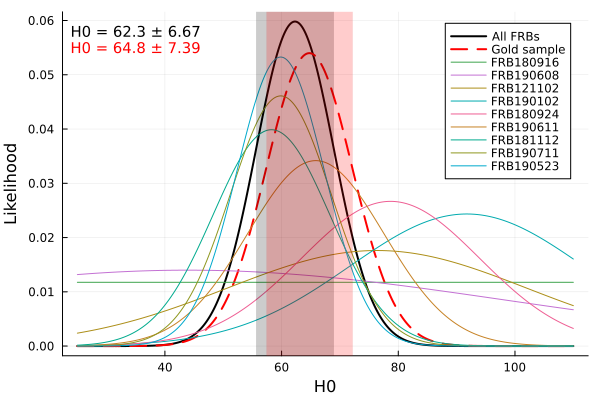

In [6]:
del_H0 = 0.1
H0_bins = collect(25:del_H0:110)
ll_all = [likelihood(frbs9.DM_obs - frbs9.DM_MW, frbs9.redshift, H0) for H0 in H0_bins]
ll_all = ll_all ./ sum(ll_all .* del_H0)
plot(H0_bins, ll_all, xlabel="H0", ylabel="Likelihood", label="All FRBs", color=:black, linewidth=2)
H0_all = H0_bins[argmax(ll_all)]
H0_all_err = (sum(ll_all.*(H0_bins .- H0_all).^2/sum(ll_all)))^0.5

ll_gold = [likelihood(frbs9.DM_obs[frbs9.optional.==0] - frbs9.DM_MW[frbs9.optional.==0], frbs9.redshift[frbs9.optional.==0], H0) for H0 in H0_bins]
ll_gold = ll_gold ./ sum(ll_gold .* del_H0)
plot!(H0_bins, ll_gold, label="Gold sample", color=:red, linewidth=2, linestyle=:dash)
H0_gold = H0_bins[argmax(ll_gold)]
H0_gold_err = (sum(ll_gold.*(H0_bins .- H0_gold).^2/sum(ll_gold)))^0.5


for i in 1:length(frbs9.DM_obs)
    ll_i = [likelihood(frbs9.DM_obs[1:i-1] - frbs9.DM_MW[1:i-1], frbs9.redshift[1:i-1], H0) for H0 in H0_bins]
    ll_i = ll_i ./ sum(ll_i .* del_H0)
    plot!(H0_bins, ll_i, label="$(frbs9.name[i])")
end

plot!([H0_all - H0_all_err, H0_all + H0_all_err], seriestype=:vspan, alpha=0.2, color=:black, label="")
plot!([H0_gold - H0_gold_err, H0_gold + H0_gold_err], seriestype=:vspan, alpha=0.2, color=:red, label="")

annotate!(35, 0.058, text("H0 = $(round(H0_all, digits=2)) ± $(round(H0_all_err, digits=2))", 10, :black))
annotate!(35, 0.055, text("H0 = $(round(H0_gold, digits=2)) ± $(round(H0_gold_err, digits=2))", 10, :red))


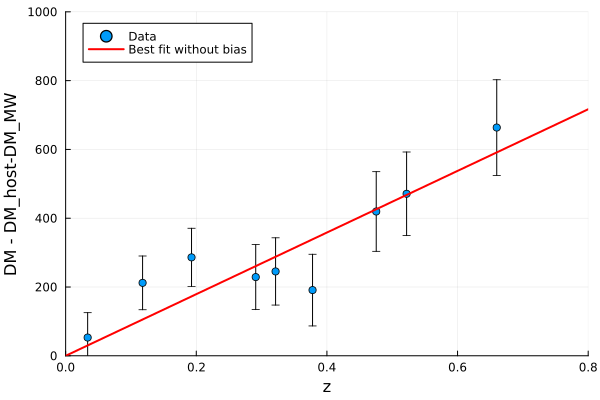

In [9]:
# Best fit Linear between DM and z
function least_square_fit(x_list, y_list, sig_y_list)
    Y = y_list
    A = x_list#hcat(ones(length(Y)), x_list)
    C = Diagonal(sig_y_list .^ 2)

    # least square fit

    X = inv(A' * inv(C) * A) * (A' * inv(C) * Y)

    slope = X[1]
    intercept = 0 #X[1]

    return slope, intercept

end

z_list = frbs9.redshift
DM_list = frbs9.DM_obs - frbs9.DM_MW - DM_host.(frbs9.redshift)
sig_DM_list = sigma_DM_sqr_i.(z_list).^0.5

slope, intercept = least_square_fit(z_list, DM_list, sig_DM_list)
plot(z_list, DM_list, yerr = sig_DM_list, seriestype=:scatter, label="Data", xlabel="z", ylabel="DM - DM_host-DM_MW")
plot!(0:0.1:0.8, slope*(0:0.1:0.8) .+ intercept, label="Best fit without bias", color=:red, linewidth=2)
xlims!(0, 0.8)
ylims!(0, 1000)

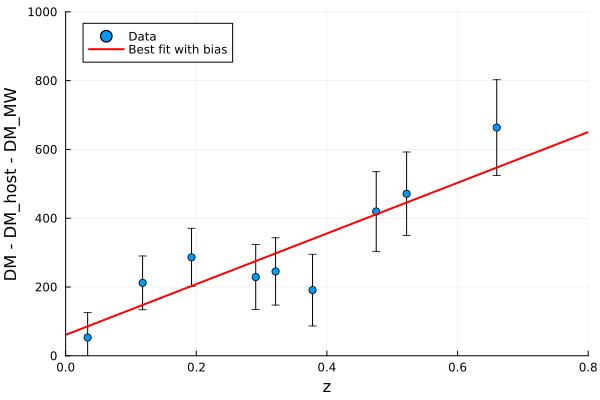

In [8]:
# Best fit Linear between DM and z
function least_square_fit(x_list, y_list, sig_y_list)
    Y = y_list
    A = hcat(ones(length(Y)), x_list)
    C = Diagonal(sig_y_list .^ 2)

    # least square fit

    X = inv(A' * inv(C) * A) * (A' * inv(C) * Y)

    slope = X[2]
    intercept = X[1]

    return slope, intercept

end

z_list = frbs9.redshift
DM_list = frbs9.DM_obs - frbs9.DM_MW - DM_host.(frbs9.redshift)
sig_DM_list = sigma_DM_sqr_i.(z_list).^0.5

slope, intercept = least_square_fit(z_list, DM_list, sig_DM_list)
plot(z_list, DM_list, yerr = sig_DM_list, seriestype=:scatter, label="Data", xlabel="z", ylabel="DM - DM_host - DM_MW")
plot!(0:0.1:0.8, slope*(0:0.1:0.8) .+ intercept, label="Best fit with bias", color=:red, linewidth=2)
xlims!(0, 0.8)
ylims!(0, 1000)
